## Visión por Computadora 1

## Trabajo Práctico N° 3

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Juan José Cardinali   | juanchijc@gmail.com       | a1809   |

### ENUNCIADO

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en *Material_TPs/TP3/images* a partir del template *Material_TPs/TP3/template*.

1. (4 puntos) Obtener una detección del logo en cada img sin falsos positivos.

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la img *coca_multi.png* con el mismo template del ítem1.

3. (2 puntos) Generalizar el algoritmo del item2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada img mostrando el nivel de confianza de la detección.

### RESOLUCIÓN

#### LIBRERÍAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import pandas as pd

#### DETECCIÓN DEL LOGO

In [2]:
# Definimos la lista de archivos a leer

def get_files(folderpath, extensions, excludes):
    # Filtra solo los archivos que tengan las extensiones deseadas y no estén en la lista de exclusiones
    files_list = []
    for file_name in os.listdir(folderpath):
        if any(file_name.endswith(ext) for ext in extensions) and file_name not in excludes:
            files_list.append(file_name)
    return files_list

folderpath = './imagenes/'  # Asegúrate de que esta ruta sea correcta

# Obtener imágenes de la carpeta
imgs_to_read = get_files(folderpath, ['.png', '.jpg'], ['coca_multi.png'])
imgs_to_read

['COCA-COLA-LOGO.jpg',
 'coca_logo_1.png',
 'coca_logo_2.png',
 'coca_retro_1.png',
 'coca_retro_2.png',
 'logo_1.png']

In [3]:
# Cantidad de imagenes a leer
n_img_to_read = len(imgs_to_read)
n_img_to_read

6

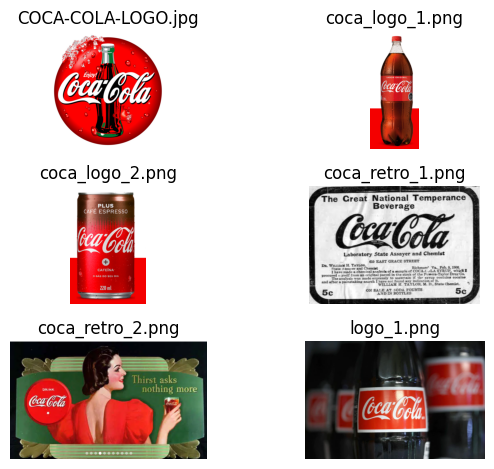

In [4]:
# Visualizamos las imágenes

# Grilla de ploteo
cols = 2
rows = (n_img_to_read + cols - 1) // cols

plt.figure()

data=[]
for idx, img_name in enumerate(imgs_to_read):

    img_path = folderpath + img_name
    img = cv.imread(img_path)
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    shape = img.shape
    data.append({
            'Nombre': img_name,
            'Alto': shape[0],
            'Ancho': shape[1],
            'Canales': shape[2] if len(shape) == 3 else 1
        })
    
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(imgRGB)
    plt.title(img_name)
    plt.axis('off')
    
plt.tight_layout() 
plt.show()

df_img_shapes = pd.DataFrame(data)

Ancho del tamplate: 400
Alto del template: 175


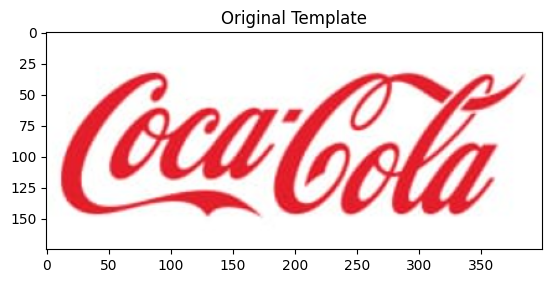

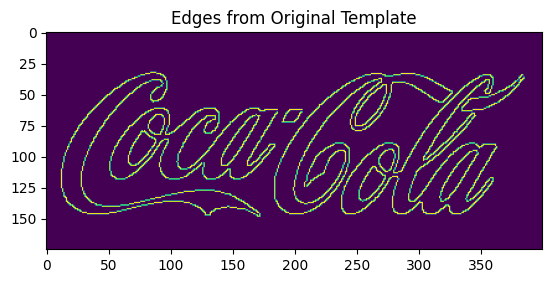

In [5]:
# Leemos el template
template = cv.imread('./templates/pattern.png')
templateRGB = cv.cvtColor(template, cv.COLOR_BGR2RGB)
templateGRAY = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
templateEDGES = cv.Canny(templateGRAY, 50, 200)

# Obtener dimensiones del template
w, h = template.shape[1], template.shape[0]
print(f'Ancho del tamplate: {w}')
print(f'Alto del template: {h}')

# Display template
plt.figure()
plt.imshow(templateRGB)
plt.title('Original Template')
plt.show()

plt.figure()
plt.imshow(templateEDGES)
plt.title('Edges from Original Template')
plt.show()

In [6]:
# Verificamos el tamaño del template respecto
df_img_shapes['TemplateEscalaOk'] = df_img_shapes.apply(
    lambda row: True if ((row['Alto'] > h) and (row['Ancho'] > w)) else False,
    axis=1
)
df_img_shapes

Nombre  Alto  Ancho  Canales  TemplateEscalaOk
0  COCA-COLA-LOGO.jpg  1389   1389        3              True
1     coca_logo_1.png   500    207        3             False
2     coca_logo_2.png   363    233        3             False
3    coca_retro_1.png   493    715        3              True
4    coca_retro_2.png   429    715        3              True
5          logo_1.png   450    687        3              True

**OBSERVACIONES:**

- Las imágenes 'coca_logo_1.png' y 'coca_logo_2.png' son más chicas que el template. O debemos achicar el template, o agrandar la imagen, o ambas en un punto intermedio.

Definimos una función general para analizar cada imagen, donde adoptamos un esquema del tipo "Multi-scale template matching", en donde comparamos el template contra múltiples escalas de la imagen objetivo.

Aplicamos el siguiente procedimiento general:

1) Convertimos la imagen objetivo y el template a escalas de grises y luego aplicamos el algoritmo de Canny para detección de bordes.

2) Definimos las multiples escalas de la imagen objetivo, definiendo un límite superior (*scale_top*), un límite inferior (*scale_bot*) y la cantidad de niveles (*levels*). En caso de que el límite superior no este definido, escalamos hacia arriba la imagen objetivo para que el template quepa en ella, si es necesario.

3) Hacemos un loop sobre las multiples escalas. La imagen de input se decrece progresivamente hasta una fracción *scale_bot*.

4) Aplicamos *Template matching* para cada escala y nos quedamos con el mejor resultado (el máximo o mínimo, según la métrica).


In [7]:
def multiscale_template_matching(img_target, template, meth, scale_top = 1, scale_bot = 0.20, levels=20):
    """ Realiza la coincidencia de patrones entre una imagen y un template, utilizando pirámides gaussianas. """
    
    # Convertir target to rgb and gray
    img_targetRGB = cv.cvtColor(img_target, cv.COLOR_BGR2RGB)
    img_targetGRAY = cv.cvtColor(img_target, cv.COLOR_BGR2GRAY)

    # Convertir template to gray and edge
    templateGRAY = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    templateEDGES = cv.Canny(templateGRAY, 50, 200)

    # Obtener dimensiones del template
    w_temp, h_temp = templateGRAY.shape[1], templateGRAY.shape[0]

    # Obtener dimensiones de la imagen
    w_img, h_img = img_targetGRAY.shape[1], img_targetGRAY.shape[0] 

    # En caso de que el template sea mayor a la imagen en alguna dimensión y scale_top==1, re-escalamos para arriba la imagen objetivo.
    if scale_top == 1:
        scale_top = max([1, w_temp/w_img, h_temp/h_img])

    # Inicializar variables para seguimiento
    best_value = -float('inf')
    if eval(meth) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        best_value *= -1 

    best_location = None
    best_res = None
    best_w = None
    best_h = None
    best_scale = None

	# loop over the scales of the image
    for scale in np.linspace(scale_bot, scale_top, levels)[::-1]:
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing
        resized = cv.resize(img_targetGRAY, (int(w_img * scale), int(h_img * scale)))
        r = w_img / float(resized.shape[1])
		
        if resized.shape[1] < w_temp or resized.shape[0] < h_temp:
            break
	
		# detect edges in the resized, grayscale image and apply template
		# matching to find the template in the image
        edged = cv.Canny(resized, 50, 200)
        method = eval(meth)
        res = cv.matchTemplate(edged, templateEDGES, method)

		# Encontramos los valores mínimos y máximos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
        if eval(meth) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            current_value = min_val
            current_loc = min_loc
        else:
            current_value = max_val
            current_loc = max_loc

        # Comprueba si la coincidencia es la mejor encontrada
        if eval(meth) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            if current_value < best_value:
                best_value = current_value
                best_location = (current_loc[0] * r, current_loc[1] * r)
                best_res = res
                best_w = w_temp * r
                best_h = h_temp * r
                best_scale = scale
        else:
            if current_value > best_value:
                best_value = current_value
                best_location = (current_loc[0] * r, current_loc[1] * r)
                best_res = res
                best_w = w_temp * r
                best_h = h_temp * r
                best_scale = scale

    # Asegurarse de que se encontró una coincidencia antes de continuar
    if best_location is None:
        print("No se encontraron coincidencias.")
        return img_target  # Retorna la imagen original si no se encontró nada

    # Marcar la mejor coincidencia encontrada en la imagen
    top_left = (int(best_location[0]), int(best_location[1]))  # Convertir a enteros
    bottom_right = (int(top_left[0] + best_w), int(top_left[1] + best_h))  # Convertir a enteros
    cv.rectangle(img_targetRGB, top_left, bottom_right,(0, 0, 255), 2)

    # Graficamos el procesamiento y la salida
    plt.figure(figsize=(10, 5))
    
    # Resultado de coincidencia
    plt.subplot(121)
    plt.imshow(best_res)
    plt.title('Matching Result')
    plt.xticks([]), plt.yticks([])
    
    # Imagen original con recuadros
    plt.subplot(122)
    plt.imshow(img_targetRGB)
    plt.title('Detected Point')
    plt.xticks([]), plt.yticks([])
    
    plt.suptitle(f'Metric: {meth}')
    plt.show()

    return best_scale	


Aplicamos el algoritmo:

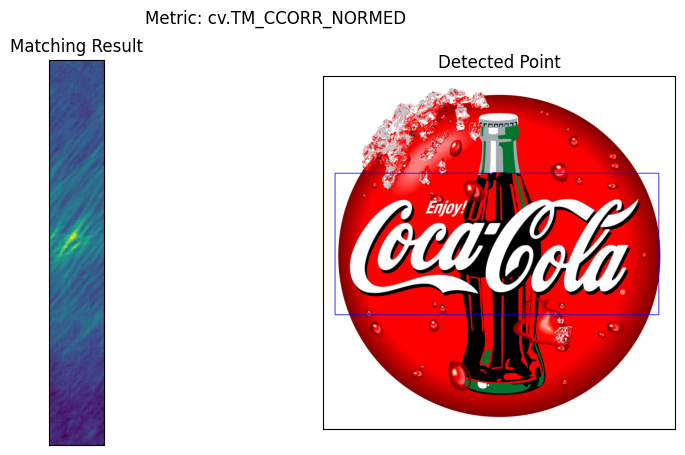

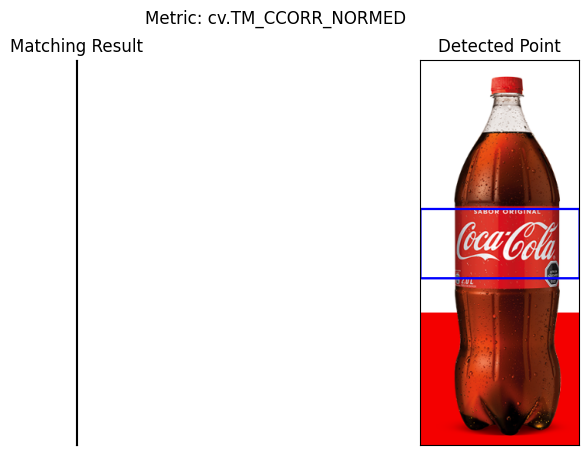

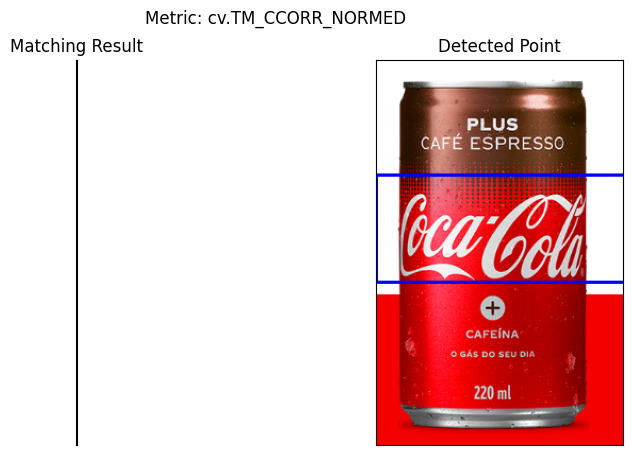

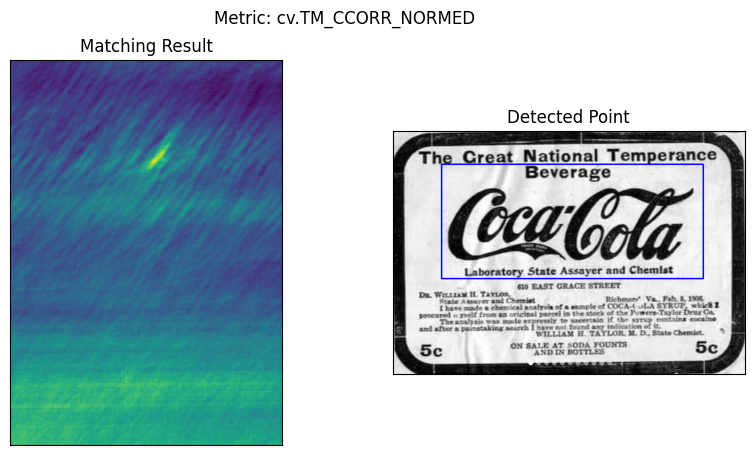

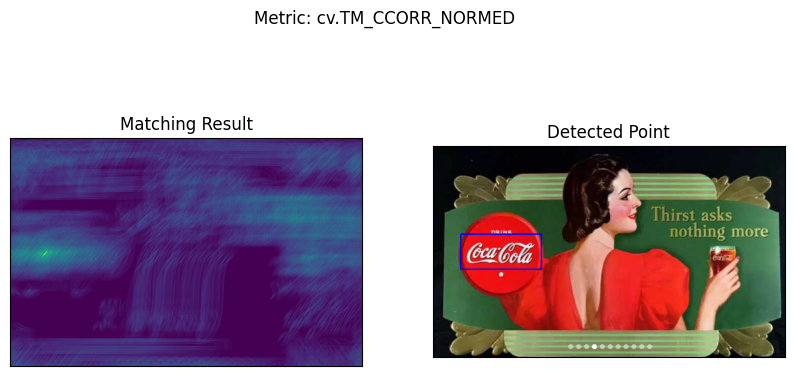

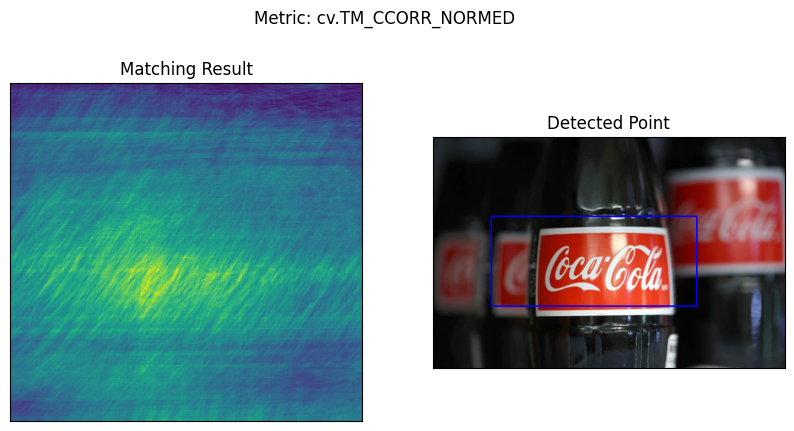

In [8]:
# Los 6 métodos posibles para comparación:
methods = ['cv.TM_CCOEFF',                  # Coeficiente de correlación (máximo)
            'cv.TM_CCOEFF_NORMED',          # Coeficiente de correlación normalizado (máximo) 
            'cv.TM_CCORR',                  # Correlación cruzada (máximo)
            'cv.TM_CCORR_NORMED',           # Correlación cruzada normalizada (máximo) 
            'cv.TM_SQDIFF',                 # Suma de diferencias al cuadrado  (mínimo)
            'cv.TM_SQDIFF_NORMED']          # Suma de diferencias al cuadrado normalizado (mínimo)

# Leemos el template
template = cv.imread('./templates/pattern.png')

sc_top_list = [1, 1, 1, 1, 5, 1]    # Mantenemos el tamaño original como máximo en todas las imágenes, menos la 5 donde se observa que el logo de coca-cola es muy chico

for i, img_name in enumerate(imgs_to_read):

    img_path = folderpath + img_name
    img_target = cv.imread(img_path)
    
    multiscale_template_matching(img_target, template, methods[3], scale_top = sc_top_list[i], levels=50)

**OBSERVACIONES:**

- El esquema de detección definido nos permitió conseguir buenos resultados en todos los casos.

### DETECCIÓN MULTIPLE

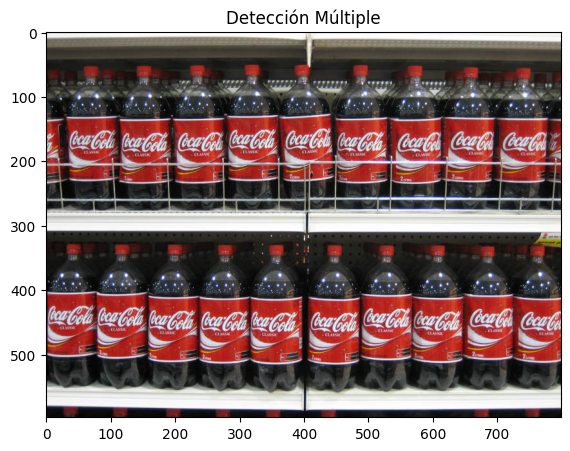

In [9]:
# Cargamos la imagen objetivo
img_target_multi = cv.imread('./Imagenes/coca_multi.png')
img_target_multiRGB = cv.cvtColor(img_target_multi, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(img_target_multiRGB)
plt.title('Detección Múltiple')
plt.show()

**OBSERVACIONES:**

- Vemos que el logo de Coca-Cola tiene un ancho aproximado de 80 pixeles. Recordando que el template tiene un ancho de 400, probamos con escalar la imagen al menos x5 hacia arriba, o escalar el template x0.20.

Modificamos la función "multiscale_template_matching" para que sea capaz de hacer detección múltiple.

In [10]:
def multiscale_multiple_detection(img_target, template, threshold = 0.30, scale_top = 1, scale_bot = 0.20, levels=20):
    
    
    # Convertir target to rgb and gray
    img_targetRGB = cv.cvtColor(img_target, cv.COLOR_BGR2RGB)
    img_targetGRAY = cv.cvtColor(img_target, cv.COLOR_BGR2GRAY)

    # Convertir template to gray and edge
    templateGRAY = cv.cvtColor(template, cv.COLOR_BGR2GRAY)
    templateEDGES = cv.Canny(templateGRAY, 50, 200)

    # Obtener dimensiones del template
    w_temp, h_temp = templateGRAY.shape[1], templateGRAY.shape[0]

    # Obtener dimensiones de la imagen
    w_img, h_img = img_targetGRAY.shape[1], img_targetGRAY.shape[0] 

    # En caso de que el template sea mayor a la imagen en alguna dimensión y scale_top==1, re-escalamos para arriba la imagen objetivo.
    if scale_top == 1:
        scale_top = max([1, w_temp/w_img, h_temp/h_img])

    # Inicializar variables para seguimiento
    best_value = -float('inf')
    best_location = None
    best_w = None
    best_h = None
    best_scale = None
    best_r = None
    objects_loc = None

	# loop over the scales of the image
    for scale in np.linspace(scale_bot, scale_top, levels)[::-1]:
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing
        resized = cv.resize(img_targetGRAY, (int(w_img * scale), int(h_img * scale)))
        r = w_img / float(resized.shape[1])
		
        if resized.shape[1] < w_temp or resized.shape[0] < h_temp:
            break
	
		# detect edges in the resized, grayscale image and apply template
		# matching to find the template in the image
        edged = cv.Canny(resized, 50, 200)
        res = cv.matchTemplate(edged, templateEDGES, cv.TM_CCORR_NORMED)

		# Encontramos los valores mínimos y máximos
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
        current_value = max_val
        current_loc = max_loc

        # Comprueba si la coincidencia es la mejor encontrada
        if current_value > best_value:
            best_value = current_value
            best_location = (current_loc[0] * r, current_loc[1] * r)
            best_w = w_temp * r
            best_h = h_temp * r
            best_scale = scale
            best_r = r
            objects_loc = np.where( res >= threshold)
    
    # Asegurarse de que se encontró una coincidencia antes de continuar
    if best_location is None:
        print("No se encontraron coincidencias.")
        return img_target  # Retorna la imagen original si no se encontró nada
    else:
        print(f'Cantidad de coincidencias detectadas: {objects_loc[0].shape[0]}')
        
    # Marcar las mejores coincidencias encontradas en la imagen
    for pt in zip(*objects_loc[::-1]):
        top_left = (int(pt[0] * best_r), int(pt[1] * best_r))  # Convertir a enteros
        bottom_right = (int(top_left[0] + best_w), int(top_left[1] + best_h))  # Convertir a enteros
        cv.rectangle(img_targetRGB, top_left, bottom_right, (0,0,255), 2)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img_targetRGB)
    plt.show()


Cantidad de coincidencias detectadas: 8


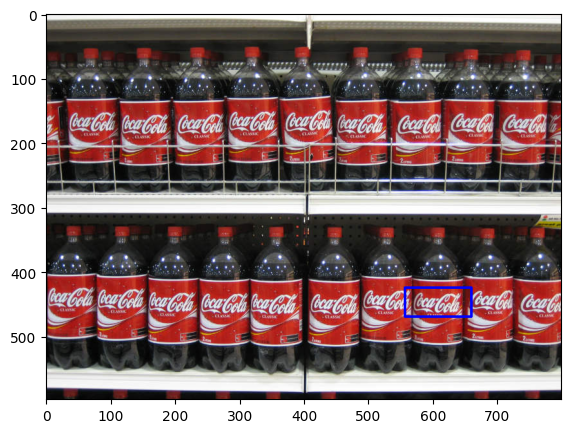

In [11]:
# Ejecutar la detección múltiple
umbral_1 = 0.15
multiscale_multiple_detection(img_target_multi, template, threshold=umbral_1, scale_top = 6, levels = 50) 

Cantidad de coincidencias detectadas: 20487


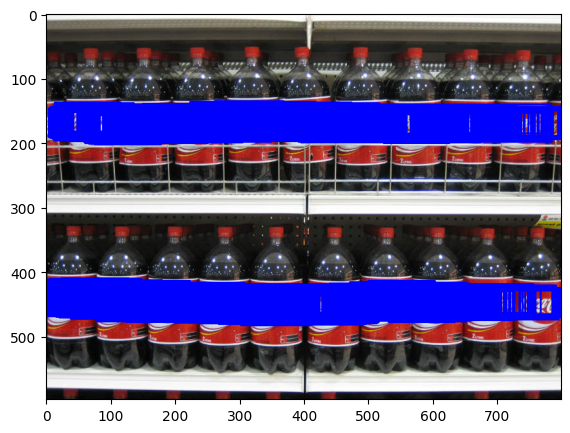

In [12]:
# Ejecutar la detección múltiple
umbral_2 = 0.10
multiscale_multiple_detection(img_target_multi, template, threshold=umbral_2, scale_top = 6, levels = 50) 

Cantidad de coincidencias detectadas: 289


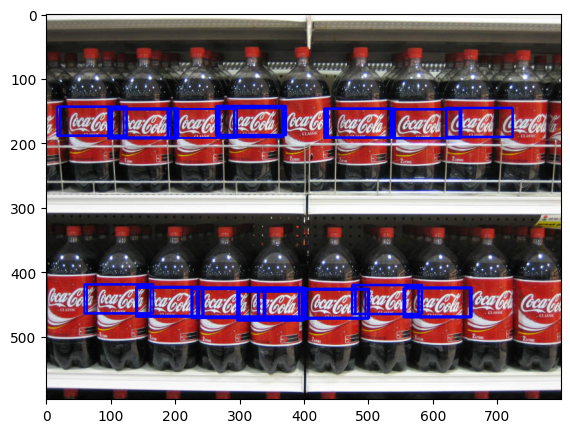

In [13]:
# Ejecutar la detección múltiple
umbral_3 = 0.5*(umbral_1+umbral_2)
multiscale_multiple_detection(img_target_multi, template, threshold=umbral_3, scale_top = 6, levels = 50) 

Cantidad de coincidencias detectadas: 2037


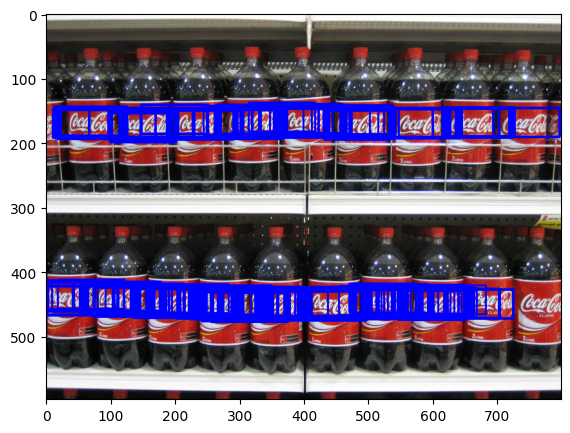

In [14]:
# Ejecutar la detección múltiple
umbral_4 = 0.5*(umbral_2+umbral_3)
multiscale_multiple_detection(img_target_multi, template, threshold=umbral_4, scale_top = 6, levels = 50) 

**OBSERVACIONES:**

- Se observa, que en función del umbral establecido, el algoritmo reconoce adecuadamente la ubicación del template.

- Se generalizó correctamente el algoritmo "multiscale_template_matching" para múltiples detecciones en función de un umbral.

- El algoritmo presenta la limitación de que solo puede encontrar dentro de la imagen objetivo, un único tamaño de template.